# CitiBike Destination Predictor

This project is a collaboration between [Elena Morais](https://github.com/elenasm7) and [Derrick Lewis](https://github.com/lewi0332)

The project requirements are to find and clean data to be fit to a classification algorithm to make predictions on the outcome. 

We chose to use data from CitiBike of all trips in 2018. This data includes time, start/stop locations, and some basic demographic identifiers. To aid in our perdiction we added daily weather information of New York City. 

- Trip Duration (seconds)
- Start Time and Date
- Stop Time and Date
- Start Station Name
- End Station Name
- Station ID
- Station Lat/Long
- Bike ID
- User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
- Gender (Zero=unknown; 1=male; 2=female)
- Year of Birth

The goal is to perdict the destination neighborhood of each journey based on the available variables. This is a multi-classification problem with a high number of outcomes. We determined that there are 51 qualifying neighborhoods in New York, which presents a sigificant challenge. 


## Data Collection and Cleaning

First we collected 1 year worth of trip data from Cibibike.com. We learn that there are 17million records in the 2018 data, which is too large for our processing capbabilities. Thus we import each month of data, and randomly sample 10% from each month to create a more manageable, yet representative list. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
for i in range(1,13):
    if i == 1:
        big = pd.read_csv('citibike_data/2018'+ str(i).zfill(2)+'-citibike-tripdata.csv')
        big = big.sample(frac=.1)
    else:
        temp = pd.read_csv('citibike_data/2018'+ str(i).zfill(2)+'-citibike-tripdata.csv')
        big = pd.concat([big, temp.sample(frac=.1)])

In [3]:
big.shape

(1754832, 15)

### NAN values

There are just 260 NaN values missing the station start and end points in the file of nearly 1.8million. This information is crucial to the prediction and thus can not be substituted. We have decidied to simply remove these rows. 

In [4]:
big.isnull().sum()

tripduration                 0
starttime                    0
stoptime                     0
start station id           267
start station name         267
start station latitude       0
start station longitude      0
end station id             267
end station name           267
end station latitude         0
end station longitude        0
bikeid                       0
usertype                     0
birth year                   0
gender                       0
dtype: int64

In [5]:
big = big.dropna()

In [ ]:
big.isnull().sum()

### Convert to DateTime 

Start and End times are saved in a format that is not readable by Pandas or our future models. We will convert the columns with this information into a standard date format, then split the relevant information into individual columns to be used as a specific independant variable.

In [6]:
big['starttime'] = pd.to_datetime(big['starttime'])
big['start_month'] = big.starttime.dt.month
big['start_day_of_week'] = big.starttime.dt.dayofweek
big['start_hour'] = big.starttime.dt.hour
big['start_date'] = big.starttime.dt.day

big['starttime'] = big.starttime.dt.date
big['starttime'] = pd.to_datetime(big['starttime'])


In [7]:
big.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,start_month,start_day_of_week,start_hour,start_date
561069,459,2018-01-09,2018-01-09 14:56:17.6960,3242.0,Schermerhorn St & Court St,40.691029,-73.991834,3382.0,Carroll St & Smith St,40.680611,-73.994758,21666,Subscriber,1971,2,1,1,14,9
483317,297,2018-01-22,2018-01-22 14:06:56.6300,3094.0,Graham Ave & Withers St,40.716981,-73.944859,3076.0,Scholes St & Manhattan Ave,40.708704,-73.944862,30833,Subscriber,1987,1,1,0,14,22


### Insert Weather Data Here: 

https://www.weather.gov/okx/centralparkhistorical

Next we connect daily weather information. The hypothesis is that this may aide in predicting a destination as fair weather might increase trips to parks and beaches. 

In [8]:
weather_df = pd.read_csv('citibike_data/2018_weather.csv')
weather_df['starttime'] = pd.to_datetime(weather_df['date'])
weather_df = weather_df.drop(['max_temp', 'min_temp','departure', 'Hdd', 'cdd', 'new_snow', 'date' ], axis=1)                                               

In [9]:
big = pd.merge(big, weather_df, on='starttime', how='left')

In [11]:
big.shape

(1754565, 22)

### Insert Neighborhood Name

Connect Neighborhood name data to our 'End Station Latitude/Longitude' to use as labels for predictions. In the most widely used context there are 51 neighborhoods in New York City. 

In [12]:
#set the token and submit it
token = 'pk.eyJ1IjoiZWxlbmFzbTciLCJhIjoiY2p0cTJvZTRiMGIzNzRkcGFjcDZxaWZ4ZCJ9.HBH-RZXHMr6bmFkKLRLvBQ'
from mapbox import Geocoder
geocoder = Geocoder(access_token=token)

def get_neighborhood(row,end_or_start):
    '''
    uses the 'end station longitude' and 'end station latitude' of each row to find 
    the neighborhood from the mapbox. Mapbox returns a json file, which we filter 
    through in the second line.
    '''
    response = geocoder.reverse(lon=row[end_or_start+' station longitude'], lat=row[end_or_start+' station latitude'])
    return response.geojson()['features'][0]['context'][0]['text']

In [13]:
def add_neighborhoods(df,end_or_start):
    
    station_names = df[end_or_start+' station name'].value_counts() #create a dataframe of all unique stations

    stn_names_li = list(station_names.keys()) #create a list of the keys
        
    stops_df = pd.DataFrame(stn_names_li)
    stops_df.rename(columns={0:end_or_start+'_station_name'},inplace=True)

    if end_or_start == 'end':
        
        #concatinate the stop names with the latitude and longitude and drop unneeded columns
        stops_w_latlong = pd.concat([stops_df, df], axis=1, join='inner')
        stops_w_latlong = stops_w_latlong[['end station latitude','end station longitude',
                                          'end station name']]  
        stops_w_latlong['end_nhbr'] = stops_w_latlong.apply(lambda row: get_neighborhood(row,'end'), axis=1)
       
        return stops_w_latlong
    
    elif end_or_start == 'start':

        stops_w_latlong = pd.concat([stops_df, df], axis=1, join='inner')
        stops_w_latlong = stops_w_latlong[['start station latitude','start station longitude',
                                           'start station name']]
        stops_w_latlong['start_nhbr'] = stops_w_latlong.apply(lambda row: get_neighborhood(row,'start'), axis=1)
        
        return stops_w_latlong

In [14]:
end_neighborhoods = add_neighborhoods(big,'end')
start_neighborhoods = add_neighborhoods(big,'start')

In [15]:
end_neighborhoods.to_csv('citibike_data/end_neighborhoods.csv')
start_neighborhoods.to_csv('citibike_data/start_neighborhoods.csv')

In [66]:
end_neighborhoods = pd.read_csv('citibike_data/end_neighborhoods.csv')
start_neighborhoods = pd.read_csv('citibike_data/start_neighborhoods.csv')

In [67]:
end_neighborhoods.drop(['Unnamed: 0'], axis=1,inplace=True)
start_neighborhoods.drop(['Unnamed: 0'],axis=1,inplace=True)

In [16]:
end_neighborhoods.drop(['end station latitude','end station longitude'], axis=1,inplace=True)
start_neighborhoods.drop(['start station latitude','start station longitude'],axis=1,inplace=True)

Merge our stop Neighborhoods to the big DataFrame

In [17]:
big = pd.merge(big, end_neighborhoods, on='end station name', how='left')

An error occured with matching, so lets's determine which neighborhoods are missing

In [ ]:
non_match_ends = pd.DataFrame(list(big[big.end_nhbr.isnull()]['end station name']))
non_match_ends.rename(columns={0:'end station name'},inplace=True)

In [ ]:
matching = pd.merge(non_match_ends,end_neighborhoods, on='end station name', how='left')

It looks like none of the missing values are in our original end neighborhood DataFrame. So, lets get the latitude and longitudes from the missing values in big and create a dataframe of the set of those.

In [ ]:
missing_stops = pd.DataFrame(list(set(zip(big[big.end_nhbr.isnull()]['end station latitude'],big[big.end_nhbr.isnull()]['end station longitude']))))
missing_stops.rename(columns={0:'end station latitude',1:'end station longitude'},inplace=True)
missing_stops['end_nhbr'] = missing_stops.apply(lambda row: get_neighborhood(row,'end'), axis=1)
missing_stops.to_csv('citibike_data/missing_end_neighborhoods.csv')

We merged the start neighborhoods with big, and saw a bunch of null values for start neighborhoods as well. So, we processed the steps from above.

In [ ]:
big_2 = pd.merge(big, start_neighborhoods, on='start station name', how='left')

In [50]:
non_match_starts = pd.DataFrame(list(big_2[big_2.start_nhbr.isnull()]['start station name']))
non_match_starts.rename(columns={0:'start station name'},inplace=True)

In [52]:
missing_starts = pd.DataFrame(list(set(zip(big_2[big_2.start_nhbr.isnull()]['start station latitude'],big_2[big_2.start_nhbr.isnull()]['start station longitude']))))
missing_starts.rename(columns={0:'start station latitude',1:'start station longitude'},inplace=True)
missing_starts['start_nhbr'] = missing_starts.apply(lambda row: get_neighborhood(row,'start'), axis=1)
missing_starts.to_csv('citibike_data/missing_start_neighborhoods.csv')

In [75]:
len(list(end_neighborhoods.end_nhbr.value_counts()))
# start_neighborhoods

53

In [78]:
len(missing_stops.end_nhbr.value_counts())

58

In [84]:
stops_total = pd.concat([end_neighborhoods.drop(['end station name'],axis=1),missing_stops])
stops_total.head()

,end station latitude,end station longitude,end_nhbr
0,40.680611,-73.994758,Carroll Gardens
1,40.708704,-73.944862,Williamsburg
2,40.670777,-73.957680,Crown Heights
3,40.765909,-73.976342,Central Park
4,40.686176,-73.996453,Cobble Hill


In [86]:
big.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name_x',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'start_month', 'start_day_of_week',
       'start_hour', 'start_date', 'ave_temp', 'precip', 'snow_depth',
       'end_nhbr_x'],
      dtype='object')

In [69]:
starts_total = pd.concat([start_neighborhoods,missing_starts])
starts_total.shape

(1234, 4)

In [87]:
big = pd.merge(big, stops_total, on=['end station latitude','end station longitude'], how='left')

In [118]:
big.drop(['end_nhbr_x','end station name_x'],inplace=True,axis=1)

In [102]:
big.dropna(inplace=True)

In [105]:
big_2.dropna(inplace=True)

In [46]:
missing_stops.to_csv('citibike_data/missing_end_neighborhoods.csv')

### Convert usertype to categories

Our CitiBike data includes a label for each trip to determine if it was made by a rider who is an annual subscriber or someone who has purchased a temporary pass. We assume that there may be destinations more likely chosen by tourist users. 

In [103]:
big.usertype = pd.Categorical(big.usertype)
big.usertype = big.usertype.cat.codes

In [106]:
big_2.usertype = pd.Categorical(big_2.usertype)
big_2.usertype = big_2.usertype.cat.codes

### Exploring Age Data

after individually looking at column distributions, there were a few interestings observations with the age data.
Lets look into this below:

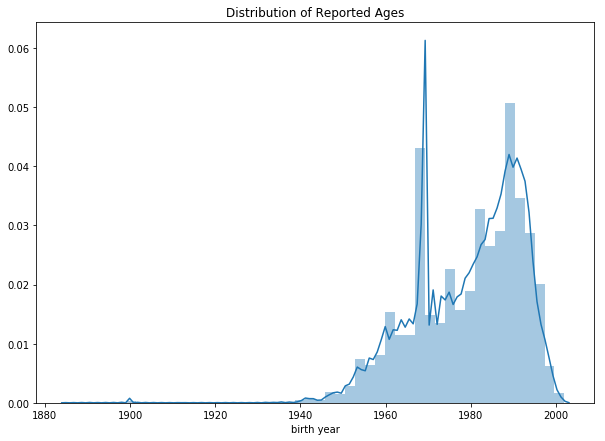

In [107]:
%matplotlib inline
fig = plt.figure(figsize=(10,7))
sns.distplot(big['birth year'])
plt.title('Distribution of Reported Ages')
plt.savefig('original_age_dist.png')

The easit thing to handle: people born way too early. We've set a cut-off age of 80. Only __0.15%__ is from people saying they were born before 1939. If you look at the data above, these all seem pretty unrealistic, so lets __drop these values.__

In [108]:
big[big['birth year'] <= 1939].shape

(105676, 24)

In [109]:
round(big[big['birth year'] <= 1939].shape[0]/big.shape[0] * 100,2)

0.15

In [110]:
big.drop(list(big[big['birth year'] <= 1939]['birth year'].index),inplace=True)

In [111]:
big_2.drop(list(big_2[big_2['birth year'] <= 1939]['birth year'].index),inplace=True)

### the youngest riders would need to be born in 2003, so we check for any riders claiming to be born after that

In [113]:
big['birth year'].max() #looks like no one is reporting to be younger

2002

### Smooth '1969' birth year


In [114]:
def change_birth_year(row,med_age_df):
    '''
    This function will be applied to each row, where ever there is a 1969 we will replace it with the birth year 
    from median_birthyear_no_69 which matches with our stop neighborhood
    '''
    if row['birth year'] == 1969:
        year = med_age_df[med_age_df['end_nhbr']== row['end_nhbr']]['birth year']
        return year.item()
    else:
        return row['birth year']

Create dataframes of the median birth year by stop neighborhood

In [119]:
median_birthyear = pd.DataFrame(big.groupby('end_nhbr')['birth year'].median())
median_birthyear.reset_index(inplace=True) 
# median_birthyear.head()

In [121]:
median_birthyear_2 = pd.DataFrame(big_2.groupby('end_nhbr')['birth year'].median())
median_birthyear_2.reset_index(inplace=True) 
# median_birthyear.head()

In [ ]:
big['update_birth_yr_2'] = big.apply(lambda row: change_birth_year(row,median_birthyear),axis=1)
big_2['update_birth_yr_2'] = big_2.apply(lambda row: change_birth_year(row,median_birthyear_2),axis=1)

Create a displot of the fixed birth year column:

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10,7))
sns.distplot(big['birth year'])
plt.title('Distribution of Reported Ages w/o 1969')
plt.savefig('fixed_age_dist.png')

### Bin Age into Categories

### Label Encode for Morning versus Evening. 

To better fit a model, using a split day rather than by hour might aide in determining a destination. The idea is that many nieghborhoods are destinations for commuters going to work in the morning and alternatively heading home in the evening. 

### Remove redundant rows - 

Now that our primary categories are set we will remove features that are not needed or redundant. 

In [ ]:
big = big.drop(['tripduration', 'starttime', 'stoptime','start station name',
                'end station id', 'bikeid', 'start station latitude', 
                'start station longitude', 'end station latitude', 
                'end station longitude','end station name', 'start_date'], axis=1)

### Save to CSV file to be used in later models 

In [ ]:
#big.to_csv('citibike_2018.csv', index=False)

### View Correlation between varibles. 

In [ ]:
sns.pairplot(df_small)

### View the Volume of stop Neighborhoods.

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(df_small.stop_nhbr)
plt.xticks(rotation=90)